In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [28]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
df_tx_bank= pd.read_csv('./../transaction_data.csv')
df_tx_bank = df_tx_bank.head(1000).copy()

In [30]:
df_processed = df_tx_bank.copy()


In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_processed['Transaction Status'] = le.fit_transform(df_processed['Transaction Status'])
df_processed['Transaction ID'] = le.fit_transform(df_processed['Transaction ID'])
df_processed['Transaction Type'] = le.fit_transform(df_processed['Transaction Type'])
df_processed['Sender Account ID'] = le.fit_transform(df_processed['Sender Account ID'])
df_processed['Receiver Account ID'] = le.fit_transform(df_processed['Receiver Account ID'])
df_processed['Device Used'] = le.fit_transform(df_processed['Device Used'])
df_processed['Network Slice ID'] = le.fit_transform(df_processed['Network Slice ID'])
df_processed['Fraud Flag'] = le.fit_transform(df_processed['Fraud Flag'])

df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'])
df_processed['Timestamp'] = df_processed['Timestamp'].dt.hour + df_processed['Timestamp'].dt.minute / 100



In [32]:
import re
df_reset = df_tx_bank.reset_index(drop=True)

for index, row in df_reset.iterrows():
    nums = re.findall(r'\d+\.?\d*', row['Geolocation (Latitude/Longitude)'])  # ['34.0522', '74.006']

    # Remove decimal points
    lat = nums[0].replace('.', '')  # '340522'
    lon = nums[1].replace('.', '')  # '74006'

    # Combine
    result = int(lat + lon)  # 34052274006
    df_processed.at[index, 'Geolocation (Latitude/Longitude)'] = result
  

In [33]:
df_processed.drop(columns=['PIN Code'], inplace=True)

df_processed

,Transaction ID,Sender Account ID,Receiver Account ID,Transaction Amount,Transaction Type,Timestamp,Transaction Status,Fraud Flag,Geolocation (Latitude/Longitude),Device Used,Network Slice ID,Latency (ms),Slice Bandwidth (Mbps)
0,949,57,88,495.90,0,10.14,0,1,34052274006,0,2,10,179
1,940,542,266,529.62,2,10.51,1,0,3568951182437,1,1,11,89
2,398,515,918,862.47,2,10.50,0,0,48856623522,1,0,4,53
3,158,409,745,1129.88,1,10.56,1,1,34052274006,1,2,10,127
4,376,567,17,933.24,0,10.25,1,1,557558376173,1,2,20,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,716,760,60,1340.76,1,10.49,1,0,3568951182437,1,1,19,224
996,159,954,469,483.36,2,11.00,0,1,557558376173,1,1,12,56
997,82,953,108,199.81,2,10.54,1,0,3405221396917,0,0,14,151
998,187,724,947,1341.86,1,10.59,1,1,5150741396917,1,2,8,95


In [34]:

scaler = StandardScaler()
X = scaler.fit_transform(df_processed.drop(columns=['Fraud Flag']))
y = columns=df_processed['Fraud Flag']


In [35]:

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2,random_state=42)

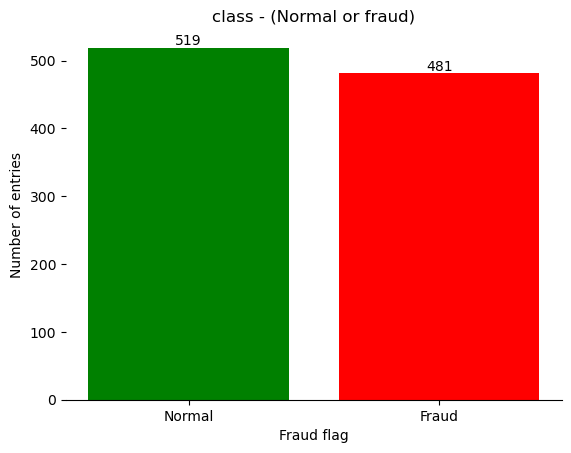

In [36]:
import matplotlib.pyplot as plt
fraud_counts = df_processed['Fraud Flag'].value_counts()

bar_colors = ['green','red']
plt.bar(fraud_counts.index, fraud_counts.values, color = bar_colors)

plt.xlabel("Fraud flag")
plt.ylabel("Number of entries")
plt.title("class - (Normal or fraud)")


for _, value in enumerate(fraud_counts.values):
    plt.text(fraud_counts.index[_], value, str(value), ha="center", va="bottom")

fraud_labels = {0: "Normal", 1: "Fraud"}
plt.xticks(fraud_counts.index,[fraud_labels[x] for x in fraud_counts.index])

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.show()

In [37]:
fraud_percentage = (df_processed["Fraud Flag"].value_counts(normalize=True) *100).loc[1]
print(f"perecentage of entries classified as fraud is {fraud_percentage: .4f}%")

perecentage of entries classified as fraud is  48.1000%


In [38]:

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))

encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(input_dim, activation='sigmoid')(encoded)

decoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [39]:
X_train_non_fraud = X_train[y_train == 0]

history = autoencoder.fit(X_train_non_fraud, X_train_non_fraud,epochs=100, batch_size=256,shuffle=True,validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.2259 - val_loss: 1.1982
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2218 - val_loss: 1.1948
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2179 - val_loss: 1.1914
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2139 - val_loss: 1.1881
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2100 - val_loss: 1.1848
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2061 - val_loss: 1.1816
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2023 - val_loss: 1.1784
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1986 - val_loss: 1.1752
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1948 - val_loss: 1.1721
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1911 - val_loss: 1.1690
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1875 - val_loss: 1.1660
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1840 - val_lo

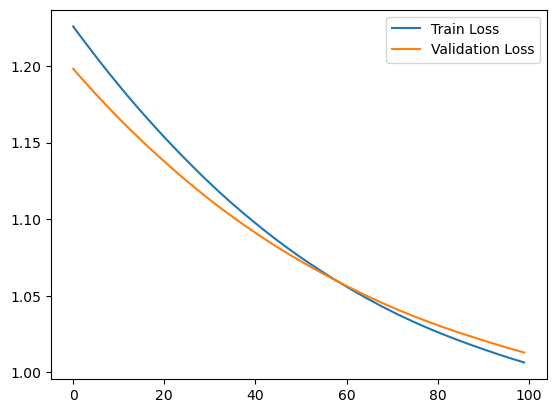

In [40]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()
plt.show()

In [41]:
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - X_test_pred), axis=1)

threshold = np.percentile(reconstruction_error, 95)

y_pred = (reconstruction_error > threshold).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [42]:
print("Performance Metric scores for GNN Model ")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

Performance Metric scores for GNN Model 
Accuracy: 0.53
Precision: 0.3
Recall: 0.03333333333333333
F1-Score: 0.06


In [43]:
X_TRAIN_PRED = autoencoder.predict(X_train)
reconstruction_error_train = np.mean(np.abs(X_train - X_TRAIN_PRED), axis=1)

X_TEST_PRED = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - X_test_pred), axis=1)


X_train_rf = np.hstack([X_train, reconstruction_error_train.reshape(-1,1)])
X_test_rf = np.hstack([X_test, reconstruction_error_test.reshape(-1,1)])

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

y_pred_rf = rf_model.predict(X_test_rf)

print("Performance Metric scores for hybrid Model ")

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf)}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Performance Metric scores for hybrid Model 
Accuracy: 0.49
Precision: 0.43617021276595747
Recall: 0.45555555555555555
F1-Score: 0.44565217391304346
